In [13]:
%pip install --upgrade scikit-learn
%pip install --upgrade numpy

  Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.2
    Uninstalling scikit-learn-0.24.2:
      Successfully uninstalled scikit-learn-0.24.2


ERROR: Could not install packages due to an OSError: [WinError 5] Accès refusé: 'C:\\Users\\jean-\\anaconda3\\Lib\\site-packages\\~klearn\\linear_model\\_cd_fast.cp39-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



  Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Can't uninstall 'joblib'. No files were found to uninstall.
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.2
    Can't uninstall 'scikit-learn'. No files were found to uninstall.
Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [2]:
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge 
from sklearn.linear_model import Lasso

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time 
import os 
%matplotlib inline

In [4]:
#parametres initiaux du notebook du P 

nb_signals = 100
nb_dates_in_sample = 1300
nb_dates_out_sample = 260
nb_assets = 80

vol_assets = 0.2/16
correl_assets = 0.8

# vol_signals = 1.0
# correl_signals = 0.0

vol_signals = 0.2/16
correl_signals = 0.8

signal_to_noise = 0.001   # la relation entre rendements X et signaux Y n'est pas parfaitement proportionnelle à cause de ça ?

rank_betas = 5

Fonction qui renvoie un dataframe avec la moyenne des sharpes prédits out sample, la moyenne des sharpes optimaux théoriques, l'écart entre les 2 moyennes, et les valeurs des paramètres utilisés en input 
-> à voir si ça vaut le coup de ne pas mettre tous les paramètres dans le dataframe renvoyé par la fonction pour accélérer les calculs ? 

In [5]:
def prediction_sharpe(modele, nb_simus,nb_signals,nb_dates_in_sample,nb_dates_out_sample,nb_assets,vol_assets,
                      correl_assets,vol_signals,correl_signals,signal_to_noise,rank_betas):
    
    liste_sharpes_predit = []
    liste_sharpes_optimaux_os=[]
    écart_sharpe_moyen=[]
    
    cov_assets = vol_assets**2 * pd.DataFrame(correl_assets * np.ones((nb_assets,nb_assets)) + (1-correl_assets)*np.eye(nb_assets))
    cov_signals = vol_signals**2 * pd.DataFrame(correl_signals * np.ones((nb_signals,nb_signals)) + (1-correl_signals)*np.eye(nb_signals))

    for i in range(nb_simus): 
        #partie generation des matrices de signaux et de rendements, d'entrainement et de test 
        
        betas = pd.DataFrame(np.random.randn(nb_signals,nb_assets)) 
        betas *= np.sqrt(signal_to_noise * np.trace(cov_assets) / np.trace(betas.T @ cov_signals @ betas))
        u,d,v = np.linalg.svd(betas)
        betas = pd.concat([pd.DataFrame(d[k] * np.outer(u[:,k],v[k,:]),index=betas.index,columns=betas.columns) for k in range(rank_betas)],keys=range(rank_betas)).groupby(level=1).sum()
        betas *= np.sqrt(signal_to_noise * np.trace(cov_assets) / np.trace(betas.T @ cov_signals @ betas))
    
        cov_noise = cov_assets - betas.T @ cov_signals @ betas
        d,P = np.linalg.eigh(cov_noise)
        cov_noise = pd.DataFrame(P @ np.diag(np.maximum(d,1e-10)) @ P.T)

        sqrt_cov_assets = np.linalg.cholesky(cov_assets)
        sqrt_cov_signals = np.linalg.cholesky(cov_signals)
        sqrt_cov_noise = np.linalg.cholesky(cov_noise)
    
        signals = pd.DataFrame(np.random.randn(nb_dates_in_sample,nb_signals) @ sqrt_cov_signals.T)
        noise = pd.DataFrame(np.random.randn(nb_dates_in_sample,nb_assets) @ sqrt_cov_noise.T)
        assets = signals @ betas+noise
    
        signals_os = pd.DataFrame(np.random.randn(nb_dates_out_sample,nb_signals) @ sqrt_cov_signals.T)
        noise_os = pd.DataFrame(np.random.randn(nb_dates_out_sample,nb_assets) @ sqrt_cov_noise.T)
        assets_os = signals_os @ betas+noise_os

    
    
        #partie entrainement et test du modele 
        modele.fit(signals,assets)
        prediction = modele.predict(signals_os) #ce truc est le vecteur des pondérations w=Y'f(Y)
        pnl_predit=(prediction * assets_os).sum(axis=1)   #Xw = le vecteur des pnls, on obtient pnl quand on somme les rendements quotidiens 
        liste_sharpes_predit.append(pnl_predit.mean()/pnl_predit.std()*16)
    
        #question : a quoi comparer pnl_predit et sharpe_predit? 
        #à pnl optimal out sample ou in sample ? ie avec Xtrain ou avec Xtest ?
        pnl_optimal_os = ((signals_os @ betas)*assets_os).sum(axis=1)
        liste_sharpes_optimaux_os.append(pnl_optimal_os.mean()/pnl_optimal_os.std()*16)
        
        écart_sharpe_moyen.append(pnl_optimal_os.mean()/pnl_optimal_os.std()*16 - pnl_predit.mean()/pnl_predit.std()*16)
       
    
    dic = {'nb_simus': nb_simus,
       'moyenne sharpes prédits': np.mean(liste_sharpes_predit),
       'moyenne sharpe optimaux': np.mean(liste_sharpes_optimaux_os),
       'écart moyen sharpe': np.mean(écart_sharpe_moyen),
     }

    resultat = pd.DataFrame([dic])

    
    return resultat 

  #autres trucs qui étaient dans le dataframe en output à la base mais qu'on retire pour accélerer calculs
'nb_signals': nb_signals,
       'nb_dates_in_sample': nb_dates_in_sample,
       'nb_dates_out_sample': nb_dates_out_sample,
       'nb_assets': nb_assets,
       'vol_assets': vol_assets,
       'correl_assets': correl_assets,
       'vol_signals': vol_signals,
       'correl_signals': correl_signals,
       'signal_to_noise': signal_to_noise,
       'rank_betas': rank_betas

In [6]:
x=prediction_sharpe(modele=Ridge(fit_intercept=False), 
                    nb_simus=10,
                    nb_signals=100,
                    nb_dates_in_sample=1300,
                    nb_dates_out_sample=260,
                    nb_assets=80,
                    vol_assets=0.2/16,
                    correl_assets=0.8,
                    vol_signals=0.2/16,
                    correl_signals=0.8,
                    signal_to_noise=0.001,
                    rank_betas=5)

remarque: le ridge ne fonctionne pas sur vs code (pb de compatibilité de python??) il faut faire tourner sur ssp cloud pour obtenir des résultats...

In [8]:
x

,nb_simus,moyenne sharpes prédits,moyenne sharpe optimaux,écart moyen sharpe
0,10,-0.009173,5.914635,5.923808


In [45]:
def pour_faire_jolis_graphiques(modele,parametre_en_abscisse, min_abscisse, max_abscisse,pas, nb_simus,nb_signals,nb_dates_in_sample,nb_dates_out_sample,nb_assets,vol_assets,
                      correl_assets,vol_signals,correl_signals,signal_to_noise,rank_betas):

    
    start_time = time.time()

    abscisse = np.arange(min_abscisse,max_abscisse,pas) #abscisse
    sharpe_os = []
    sharpe_theo = []
    #ecart_sharpe = []

    
    if parametre_en_abscisse == 'nombre_signaux' : 
        
        for i in abscisse : 

            print(i)
            sharpe_os.append(prediction_sharpe(modele, nb_simus, i,nb_dates_in_sample,nb_dates_out_sample,nb_assets,vol_assets,
                      correl_assets,vol_signals,correl_signals,signal_to_noise,rank_betas).iloc[0,1])
            sharpe_theo.append(prediction_sharpe(modele, nb_simus,i,nb_dates_in_sample,nb_dates_out_sample,nb_assets,vol_assets,
                      correl_assets,vol_signals,correl_signals,signal_to_noise,rank_betas).iloc[0,2])
            #ecart_sharpe.append(prediction_sharpe(modele, nb_simus,i,nb_dates_in_sample,nb_dates_out_sample,nb_assets,vol_assets,
             #         correl_assets,vol_signals,correl_signals,signal_to_noise,rank_betas).iloc[0,3])


    elif parametre_en_abscisse == 'nombre_dates_in_sample' : 

        for i in abscisse:

            print(i)
            sharpe_os.append(prediction_sharpe(modele, nb_simus, nb_signals,i,nb_dates_out_sample,nb_assets,vol_assets,
                      correl_assets,vol_signals,correl_signals,signal_to_noise,rank_betas).iloc[0,1])
            sharpe_theo.append(prediction_sharpe(modele, nb_simus,nb_signals,i,nb_dates_out_sample,nb_assets,vol_assets,
                      correl_assets,vol_signals,correl_signals,signal_to_noise,rank_betas).iloc[0,2])
            #ecart_sharpe.append(prediction_sharpe(modele, nb_simus,nb_signals,i,nb_dates_out_sample,nb_assets,vol_assets,
             #         correl_assets,vol_signals,correl_signals,signal_to_noise,rank_betas).iloc[0,3])


    elif parametre_en_abscisse == 'nombre_dates_out_sample' : 

        for i in abscisse:
            print(i)
            sharpe_os.append(prediction_sharpe(modele, nb_simus, nb_signals,nb_dates_in_sample,i,nb_assets,vol_assets,
                      correl_assets,vol_signals,correl_signals,signal_to_noise,rank_betas).iloc[0,1])
            sharpe_theo.append(prediction_sharpe(modele, nb_simus,nb_signals,nb_dates_in_sample,i,nb_assets,vol_assets,
                      correl_assets,vol_signals,correl_signals,signal_to_noise,rank_betas).iloc[0,2])
            #ecart_sharpe.append(prediction_sharpe(modele, nb_simus,nb_signals,nb_dates_in_sample,i,nb_assets,vol_assets,
             #         correl_assets,vol_signals,correl_signals,signal_to_noise,rank_betas).iloc[0,3])


    elif parametre_en_abscisse == 'nombre_actifs' : 

        for i in abscisse:
            print(i)
            sharpe_os.append(prediction_sharpe(modele, nb_simus, nb_signals,nb_dates_in_sample,nb_dates_out_sample,i,vol_assets,
                      correl_assets,vol_signals,correl_signals,signal_to_noise,rank_betas).iloc[0,1])
            sharpe_theo.append(prediction_sharpe(modele, nb_simus,nb_signals,nb_dates_in_sample,nb_dates_out_sample,i,vol_assets,
                      correl_assets,vol_signals,correl_signals,signal_to_noise,rank_betas).iloc[0,2])
            #ecart_sharpe.append(prediction_sharpe(modele, nb_simus,nb_signals,nb_dates_in_sample,nb_dates_out_sample,i,vol_assets,
             #         correl_assets,vol_signals,correl_signals,signal_to_noise,rank_betas).iloc[0,3])


    elif parametre_en_abscisse == 'vol_actifs' : 

        for i in abscisse:
            print(i)
            sharpe_os.append(prediction_sharpe(modele, nb_simus, nb_signals,nb_dates_in_sample,nb_dates_out_sample,nb_assets,i,
                      correl_assets,vol_signals,correl_signals,signal_to_noise,rank_betas).iloc[0,1])
            sharpe_theo.append(prediction_sharpe(modele, nb_simus,nb_signals,nb_dates_in_sample,nb_dates_out_sample,nb_assets,i,
                      correl_assets,vol_signals,correl_signals,signal_to_noise,rank_betas).iloc[0,2])
            #ecart_sharpe.append(prediction_sharpe(modele, nb_simus,nb_signals,nb_dates_in_sample,nb_dates_out_sample,nb_assets,i,
             #         correl_assets,vol_signals,correl_signals,signal_to_noise,rank_betas).iloc[0,3])


    elif parametre_en_abscisse == 'correl_actifs' : 

        for i in abscisse:
            print(i)
            sharpe_os.append(prediction_sharpe(modele, nb_simus, nb_signals,nb_dates_in_sample,nb_dates_out_sample,nb_assets,vol_assets,
                      i,vol_signals,correl_signals,signal_to_noise,rank_betas).iloc[0,1])
            sharpe_theo.append(prediction_sharpe(modele, nb_simus,nb_signals,nb_dates_in_sample,nb_dates_out_sample,nb_assets,vol_assets,
                      i,vol_signals,correl_signals,signal_to_noise,rank_betas).iloc[0,2])
            #ecart_sharpe.append(prediction_sharpe(modele, nb_simus,nb_signals,nb_dates_in_sample,nb_dates_out_sample,nb_assets,vol_assets,
             #         i,vol_signals,correl_signals,signal_to_noise,rank_betas).iloc[0,3])



    elif parametre_en_abscisse == 'vol_signaux' : 

        for i in abscisse:
            print(i)
            sharpe_os.append(prediction_sharpe(modele, nb_simus, nb_signals,nb_dates_in_sample,nb_dates_out_sample,nb_assets,vol_assets,
                      correl_assets,i,correl_signals,signal_to_noise,rank_betas).iloc[0,1])
            sharpe_theo.append(prediction_sharpe(modele, nb_simus,nb_signals,nb_dates_in_sample,nb_dates_out_sample,nb_assets,vol_assets,
                      correl_assets,i,correl_signals,signal_to_noise,rank_betas).iloc[0,2])
            #ecart_sharpe.append(prediction_sharpe(modele, nb_simus,nb_signals,nb_dates_in_sample,nb_dates_out_sample,nb_assets,vol_assets,
             #         correl_assets,i,correl_signals,signal_to_noise,rank_betas).iloc[0,3])



    elif parametre_en_abscisse == 'correl_signaux' : 

        for i in abscisse:
            print(i)
            sharpe_os.append(prediction_sharpe(modele, nb_simus, nb_signals,nb_dates_in_sample,nb_dates_out_sample,nb_assets,vol_assets,
                      correl_assets,vol_signals,i,signal_to_noise,rank_betas).iloc[0,1])
            sharpe_theo.append(prediction_sharpe(modele, nb_simus,nb_signals,nb_dates_in_sample,nb_dates_out_sample,nb_assets,vol_assets,
                      correl_assets,vol_signals,i,signal_to_noise,rank_betas).iloc[0,2])
            #ecart_sharpe.append(prediction_sharpe(modele, nb_simus,nb_signals,nb_dates_in_sample,nb_dates_out_sample,nb_assets,vol_assets,
             #         correl_assets,vol_signals,i,signal_to_noise,rank_betas).iloc[0,3])



    elif parametre_en_abscisse == 'signal_sur_bruit' : 

        for i in abscisse:
            print(i)
            sharpe_os.append(prediction_sharpe(modele, nb_simus, nb_signals,nb_dates_in_sample,nb_dates_out_sample,nb_assets,vol_assets,
                      correl_assets,vol_signals,correl_signals,i,rank_betas).iloc[0,1])
            sharpe_theo.append(prediction_sharpe(modele, nb_simus,nb_signals,nb_dates_in_sample,nb_dates_out_sample,nb_assets,vol_assets,
                      correl_assets,vol_signals,correl_signals,i,rank_betas).iloc[0,2])
            #ecart_sharpe.append(prediction_sharpe(modele, nb_simus,nb_signals,nb_dates_in_sample,nb_dates_out_sample,nb_assets,vol_assets,
             #         correl_assets,vol_signals,correl_signals,i,rank_betas).iloc[0,3])



    else: 

        return ("pas un paramètre à faire varier fdp")



    end_time = time.time()
    execution_time = end_time - start_time
    print("Le temps d'exécution est de {:.2f} secondes.".format(execution_time))

    return abscisse, sharpe_os, sharpe_theo

    

vieux code qui était dans la fonction pour produire les graphiques, mais mieux vaut que la fonction renvoie juste des vecteurs et qu'on produise le graphique de notre choix


    plt.plot(abscisse, sharpe_os, label='sharpe out sample')
    plt.plot(abscisse, sharpe_theo, label='sharpe théorique optimal')
    #plt.plot(abscisse, ecart_sharpe, label='écart entre sharpe OS et théorique')

    # Ajouter des labels et un titre
    plt.xlabel(parametre_en_abscisse)
    plt.ylabel('Valeurs des sharpes')
    plt.title(f'sharpe moyen pour {nb_simus} simulations avec le modèle {modele}')

    # Ajouter une légende
    plt.legend()


    chemin_sauvegarde = os.path.join('C:\\Users\\jean-\Desktop\\Cours ENSAE\\statapp\\graphiques statapp sharpes modele signal\\', f"{nom_graphe}.png")

    
    plt.savefig(chemin_sauvegarde, dpi=300)

    # Afficher le tracé
    plt.show()

260
520
780
1040
1300
1560
1820
2080
2340
2600
2860
3120
3380
3640
3900
4160
4420
4680
4940


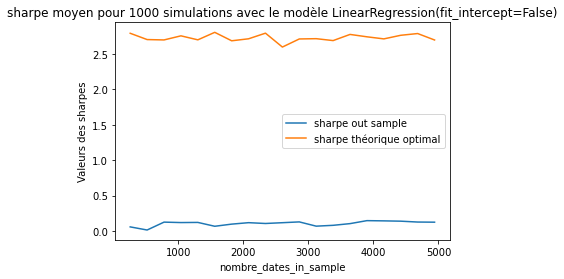

Le temps d'exécution est de 2741.77 secondes.


In [34]:
jolis_graphiques(modele=LinearRegression(fit_intercept=False), 
                 nom_graphe='RegLin - sharpe en fonction de nb dates in sample - 1000 simus - 20 actifs',
                 parametre_en_abscisse='nombre_dates_in_sample', 
                 min_abscisse=260, 
                 max_abscisse=260*20,
                 pas=260, 
                 nb_simus=1000,
                 nb_signals=100,
                 nb_dates_in_sample=1300,
                 nb_dates_out_sample=260,
                 nb_assets=20,
                 vol_assets=0.2/16,
                 correl_assets=0.8,
                 vol_signals=0.2/16,
                 correl_signals=0.8,
                 signal_to_noise=0.001,
                 rank_betas=5)

260
520
780
1040
1300
1560
1820
2080
2340
2600
2860
3120
3380
3640
3900
4160
4420
4680
4940


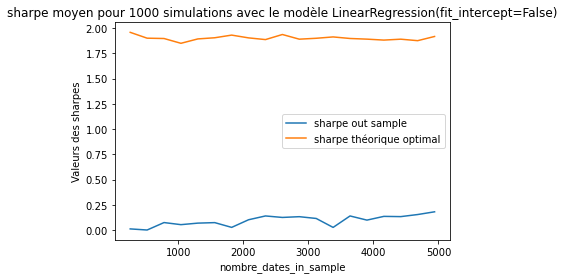

Le temps d'exécution est de 2327.35 secondes.


In [35]:
jolis_graphiques(modele=LinearRegression(fit_intercept=False), 
                 nom_graphe='RegLin - sharpe en fonction de nb dates in sample - 1000 simus - 10 actifs',
                 parametre_en_abscisse='nombre_dates_in_sample', 
                 min_abscisse=260, 
                 max_abscisse=260*20,
                 pas=260, 
                 nb_simus=1000,
                 nb_signals=100,
                 nb_dates_in_sample=1300,
                 nb_dates_out_sample=260,
                 nb_assets=10,
                 vol_assets=0.2/16,
                 correl_assets=0.8,
                 vol_signals=0.2/16,
                 correl_signals=0.8,
                 signal_to_noise=0.001,
                 rank_betas=5)

260
520
780
1040
1300
1560
1820
2080
2340
2600
2860
3120
3380
3640
3900
4160
4420
4680
4940


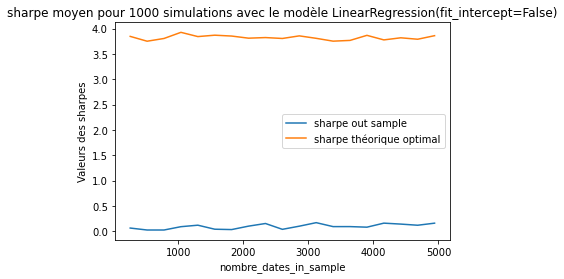

Le temps d'exécution est de 2894.56 secondes.


In [10]:
jolis_graphiques(modele=LinearRegression(fit_intercept=False), 
                 nom_graphe='RegLin - sharpe en fonction de nb dates in sample - 1000 simus - 40 actifs',
                 parametre_en_abscisse='nombre_dates_in_sample', 
                 min_abscisse=260, 
                 max_abscisse=260*20,
                 pas=260, 
                 nb_simus=1000,
                 nb_signals=100,
                 nb_dates_in_sample=1300,
                 nb_dates_out_sample=260,
                 nb_assets=40,
                 vol_assets=0.2/16,
                 correl_assets=0.8,
                 vol_signals=0.2/16,
                 correl_signals=0.8,
                 signal_to_noise=0.001,
                 rank_betas=5)

remarque: pour faire varier le nombre d'actifs: on ne peut pas mettre moins d'actifs que le rang de betas. 

In [33]:
x,y,z=pour_faire_jolis_graphiques(modele=LinearRegression(fit_intercept=False), 
                 nom_graphe='RegLin - sharpe en fonction de nb actifs - 1000 simus',
                 parametre_en_abscisse='nombre_actifs', 
                 min_abscisse=5, 
                 max_abscisse=105,
                 pas=5, 
                 nb_simus=1000,
                 nb_signals=100,
                 nb_dates_in_sample=1300,
                 nb_dates_out_sample=260,
                 nb_assets=20,
                 vol_assets=0.2/16,
                 correl_assets=0.8,
                 vol_signals=0.2/16,
                 correl_signals=0.8,
                 signal_to_noise=0.001,
                 rank_betas=5)

print(x,y,z)

5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100
Le temps d'exécution est de 1694.24 secondes.
[  5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85  90
  95 100] [0.09878559631453435, 0.052602631518488215, 0.1316882313593446, 0.037254059756171055, 0.07594700729744677, 0.056357229171135274, 0.04320662169362957, 0.10676267854900266, 0.06421542634297966, 0.07134379330739123, 0.04286212355159139, 0.062256837085514376, 0.05685775809072548, 0.07372642404168288, 0.10031104073040746, 0.0927113310471434, 0.03896039304076194, 0.05895719154845019, 0.05331648773545113, 0.05209777008533142] [1.2915762888436402, 1.8919581989082515, 2.344645711506915, 2.719087034798742, 3.0734025202038358, 3.2997967177747367, 3.5175636834325195, 3.7790820878716156, 4.005129067558764, 4.252288812320694, 4.485511709926688, 4.71955415429015, 4.8660446212736685, 4.975339731373966, 5.305383828845576, 5.312802014879959, 5.394131749355208, 5.5868758564890975, 5.76909341685379, 5.915340538257654]


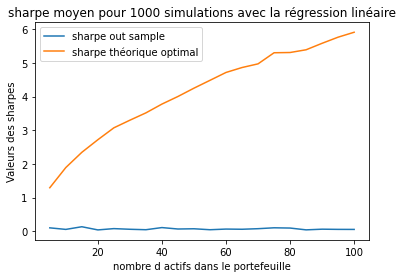

In [53]:
plt.plot(x, y, label='sharpe out sample')
plt.plot(x, z, label='sharpe théorique optimal')
#plt.plot(x, z-y, label='écart entre sharpe OS et théorique')

    # Ajouter des labels et un titre
plt.xlabel('nombre d actifs dans le portefeuille')
plt.ylabel('Valeurs des sharpes')
plt.title(f'sharpe moyen pour {1000} simulations avec la régression linéaire')

    # Ajouter une légende
plt.legend()


chemin_sauvegarde ="C:\\Users\\jean-\Desktop\\Cours ENSAE\\statapp\\graphiques statapp sharpes modele signal\\regression linéaire contre nb actifs, 1000 simus, focus sharpe out sample.png"

    
plt.savefig(chemin_sauvegarde, dpi=300)

    # Afficher le tracé
plt.show()

remarque: la correlation entre actif doit etre dans [0,1[ sinon la matrice sqrt_cov_assets n'est pas SDP 

In [55]:
abscisse_correl, sharpe_out_sample_correl, sharpe_theo_correl = pour_faire_jolis_graphiques(modele=LinearRegression(fit_intercept=False), 
                 parametre_en_abscisse='correl_actifs', 
                 min_abscisse=0, 
                 max_abscisse=1,
                 pas=0.05,
                 nb_simus=1000,
                 nb_signals=100,
                 nb_dates_in_sample=1300,
                 nb_dates_out_sample=260,
                 nb_assets=20,
                 vol_assets=0.2/16,
                 correl_assets=0.8,
                 vol_signals=0.2/16,
                 correl_signals=0.8,
                 signal_to_noise=0.001,
                 rank_betas=5)

print(abscisse_correl)

0.0


KeyboardInterrupt: 

idée: ce serait plus pertinent de produire un graphe qui renvoie le ratio sharpe_out_sample/(sharpe_theorique - sharpe_out_sample) associé à différentes méthodes, avec en abscisse le parametre qu'on fait varier.

Comme ça on capture à la fois la performance prédictive du modele au numérateur et l'overfitting au dénominateur et on peut comparer les différentes méthodes entre elles 